# Consensus Example

For this example, the agents are to reach
consensus in the x-axis while reaching individual tracking
goals in the y-axis. Thus each agent’s subproblem is a linear
quadratic tracking problem in y-space with a quadratic cost
on the control activation.

The coordination sheaf is defined
over a fully connected communication topology, where each
restriction map is simply the projection onto the x coordinate.
Edge potentials are the standard norm squared potential
function encoding the consensus goal.

In [1]:
using Test
using AlgebraicOptimization
using LinearAlgebra
using BlockArrays
using Plots
using CSV, Tables
include("../../../examples/paper-examples/PaperPlotting.jl")
using .PaperPlotting

First, we set up each agent's dynamics according to the equation x' = Ax + Bu.

In [2]:
dt = 0.1  # Discretization step size
A = [1 dt 0 0; 0 1 0 0; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt 0; 0 0; 0 dt]
C = [1 0 0 0]
system = DiscreteLinearSystem(A, B, C)

DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0])

Second, we set up Q and R matrices for the quadratic objective function for each agent: x'Qx + u'Ru.

In [3]:
Q = I(4)
Q[1, 1] = 0    # First variable is unconstrained
R = I(2)

2×2 LinearAlgebra.Diagonal{Bool, Vector{Bool}}:
 1  ⋅
 ⋅  1

Third, set up system properties of time horoizon and control bounds.

In [4]:
N = 10
control_bounds = [-2.0, 2.0]
params1 = MPCParams(Q, R, system, control_bounds, N, [0, 0, 2.0, 0])
params2 = MPCParams(Q, R, system, control_bounds, N, [0, 0, 4.0, 0])
params3 = MPCParams(Q, R, system, control_bounds, N, [0, 0, 6.0, 0])

MPCParams(Bool[0 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1], Bool[1 0; 0 1], DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0]), [-2.0, 2.0], 10, [0.0, 0.0, 6.0, 0.0])

Fourth, we set up the communication pattern. For this example, we have a triangular connection
pattern between the 3 agents. Each agent shares only its x coordinate with its neighbor.

In [5]:
c = CellularSheaf([4, 4, 4], [1, 1, 1])
set_edge_maps!(c, 1, 2, 1, C, C)
set_edge_maps!(c, 1, 3, 2, C, C)
set_edge_maps!(c, 2, 3, 3, C, C)

1×4 Matrix{Int64}:
 -1  0  0  0

Fifth, we set up the solver

In [6]:
x_init = BlockArray(5 * rand(-1:0.1:1, 12), c.vertex_stalks)
prob = MultiAgentMPCProblem([params1, params2, params3], c, x_init)
alg = ADMM(2.0, 10)
num_iters = 100

100

Finally, we run the solver, which outputs the optimized trajectory and controls for each agent.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



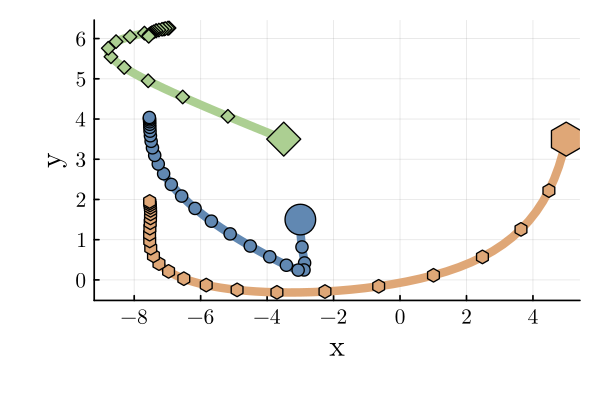

In [7]:
trajectory, controls = do_mpc!(prob, alg, num_iters)

PaperPlotting.plot_trajectories(trajectory, [1 0 0 0; 0 0 1 0])